In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import optimize
import plotly.graph_objs as go
import numdifftools
import lmfit
import corner
import emcee
from scipy import signal

In [2]:
def intensity(kinetic_energy, max_energy, Z):
    """spectrum function"""
    me = 0.511*1000 #keV
    return np.sqrt(kinetic_energy**2+2*kinetic_energy*me)*(max_energy - kinetic_energy)**2*(kinetic_energy + me)*Fermi_function(Z, kinetic_energy)

def Fermi_function(Z, kinetic_energy):
    me = 0.511*1000 #keV
    a = 1/137
    E = kinetic_energy + me
    pc = np.sqrt(E**2 - me**2)
    x = Z*a*E/pc
    return 2*np.pi*x/(1-np.exp(-2*np.pi*x))

In [3]:
def B(x, k, i, t):
    """
    B-spline
    t : numpy array
      knots
    k, i : int
      spline number
    return: B_ki spline at point x
    """
    if k == 0:
        return 1.0 if t[i] <= x < t[i+1] else 0.0
    if t[i+k] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i])/(t[i+k] - t[i]) * B(x, k-1, i, t)
    if t[i+k+1] == t[i+1]:
        c2 = 0.0
    else:
        c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B(x, k-1, i+1, t)
    return c1 + c2



def T(x, x_knots, b):
    """
    time strategy
    x_knots : numpy array
    b : numpy array
      weights
    return: time at point x
    """
    t = x_knots
    T = 1e-19
    for i in range(1, len(t)-5):
        T += b[i-1]*B(x, 3, i, t)
    
    return T

In [4]:
def experimental_lin(kinetic_energy, max_energy, noise, calibr, lin, Z=2, me=511):
    """
    function for fitting with linear additive
    """
    return calibr*(np.sqrt(kinetic_energy**2+2*kinetic_energy*me)*(max_energy - kinetic_energy)**2*(kinetic_energy + me)*Fermi_function(Z, kinetic_energy) -lin*(max_energy - kinetic_energy)) + noise 

def intensity_lin(kinetic_energy, max_energy, ampl, Z=2, me=511):
    """
    function for intensity with linear additive
    """
    return np.sqrt(kinetic_energy**2+2*kinetic_energy*me)*(max_energy - kinetic_energy)**2*(kinetic_energy + me)*Fermi_function(Z, kinetic_energy)-ampl*(max_energy - kinetic_energy)

In [5]:
def div_max(kinetic_energy, max_energy=18.57, ampl=10**4, Z=2, me=511):
    """
    derivative of max energy parameter 
    """
    return np.sqrt(kinetic_energy ** 2 + 2 * kinetic_energy * me) * 2 * (max_energy - kinetic_energy) * (
            kinetic_energy + me) * Fermi_function(Z, kinetic_energy) - ampl


def div_ampl(kinetic_energy, max_energy=18.57, ampl=10**4, Z=2, me=511):
    """
    derivative of additive amplitude parameter 
    """
    return -(max_energy - kinetic_energy)


def div_cal(kinetic_energy, max_energy=18.57, ampl=10**4, Z=2, me=511):
    """
    derivative of calibration parameter 
    """
    return np.sqrt(kinetic_energy ** 2 + 2 * kinetic_energy * me) * (max_energy - kinetic_energy) ** 2 * (
            kinetic_energy + me) * Fermi_function(Z, kinetic_energy) -ampl*(max_energy - kinetic_energy)


#derivative of noise is equal to one


def apriori(theta, theta0, sigma):
    """
    aprior information about maximum energy
    theta : double
    theta0 : double
    sigma : double
    """
    return (theta - theta0)**2/sigma**4 


def inversed_fisher_information_postorerior(b, x_knots, derivatives, KEs, dist, sigma, parameter_number):
    """
    inverse fisher infromation matrix
    x_knots : numpy array
    derivatives : numpy array
      array of derivatives
    dist : numpy array
      intensity array
    normolize : double
      area normalization (as not to change the total time)
    return: max energy sigma
    """
    time = np.array([T(x, x_knots, b) for x in KEs])
    summ = np.sum(time)
    b0 = np.ones(len(x_knots) - 6)
    y0 = np.array([T(x, x_knots, b0) for x in KEs])
    normolize = np.sum(y0)
    time = time * normolize / summ
    length = len(derivatives)
    FIM = np.zeros((length, length))
    delta = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            FIM[i][j] = np.sum(time*derivatives[i]*derivatives[j]/dist)
    
    FIM[parameter_number][parameter_number] = FIM[parameter_number][parameter_number] + 1/sigma**2
    return np.sqrt(np.linalg.inv(FIM)[0][0])
    #delta[0][0] = aprior
    #FIM_inversed = np.linalg.inv(FIM)
    #if np.linalg.norm(FIM_inversed*delta) < 1:
     #   inversed = FIM_inversed - np.dot(np.dot(FIM_inversed, delta), FIM_inversed)
      #  return np.sqrt(inversed[0][0])
    #else:
     #   print("Singular matrix: norm > 1")

In [6]:
max_energy = 18.57 
n = 1000 # number of points
KEs = np.linspace(0.001, max_energy - 0.2, n) #kinetic energies 

derivatives = np.array([div_max(KEs), np.ones(len(KEs)), div_cal(KEs), div_ampl(KEs)]) 
dist = intensity_lin(KEs, max_energy, 10 ** 4) #intensity
a = 0 #start of grid
b = max_energy #end of grid
x_knots = np.concatenate([np.linspace(a-2, a-0.5, 3), np.linspace(a, b, 10), np.linspace(b + 1.5, b + 3.5, 3)])
b0 = np.ones(len(x_knots) - 6) #initial weights
bl = tuple(np.zeros(len(x_knots) - 6)) #lower bound
bw = tuple(np.ones(len(x_knots) - 6)*50) #upper bound
bnds = optimize.Bounds(bl, bw) #bounds

In [7]:
bo = [3.44899946, 0.        , 0.        , 0.        , 0.        ,
       1.31942577, 1.37361597, 0.        , 0.        , 0.36451806]
bao = [4.25735772, 0.        , 0.        , 0.        , 2.19992923,
       0.70822065, 0.        , 0.        , 0.        , 0.17843025]

In [8]:
#sigma = 7.60269049e-05
#parameter_number = 2

for parameter_number, sigma in enumerate([2.56014500e-04, 5.24724808e+01, 1.30420671e-04, 1.01301596e+02]):
    print(parameter_number)
    print('initial')
    print(inversed_fisher_information_postorerior(b0, x_knots, derivatives, KEs, dist, sigma, parameter_number))
    print(inversed_fisher_information_postorerior(b0, x_knots, derivatives, KEs, dist, sigma*10**5, parameter_number))

    print('optimal')
    print(inversed_fisher_information_postorerior(bo, x_knots, derivatives, KEs, dist, sigma, parameter_number))
    print(inversed_fisher_information_postorerior(bo, x_knots, derivatives, KEs, dist, sigma*10**5, parameter_number))

    print('improvment')
    print(inversed_fisher_information_postorerior(b0, x_knots, derivatives, KEs, dist, sigma, parameter_number)/inversed_fisher_information_postorerior(bo, x_knots, derivatives, KEs, dist, sigma, parameter_number))
    print(inversed_fisher_information_postorerior(b0, x_knots, derivatives, KEs, dist, sigma*10**5, parameter_number)/inversed_fisher_information_postorerior(bo, x_knots, derivatives, KEs, dist, sigma*10**5, parameter_number))

0
initial
0.0001897295634000577
0.000282585168494957
optimal
0.00014890296620367118
0.00018304865327578468
improvment
1.2741825649097107
1.5437708141409194
1
initial
0.0002824636186174688
0.0002825851685121572
optimal
0.00018241465112499186
0.00018304865328037877
improvment
1.5484700207765805
1.5437708141961397
2
initial
0.0002741497676984359
0.0002825851685111265
optimal
0.00018242995460835952
0.0001830486532803703
improvment
1.5027672855972607
1.5437708141905804
3
initial
0.00025567780881865555
0.00028258516850871546
optimal
0.0001794496572627757
0.00018304865328000542
improvment
1.4247885045790627
1.543770814180486


In [27]:
optimize.minimize(inversed_fisher_information_postorerior, x0=b0, args=(x_knots, derivatives, KEs, dist, max_energy_error), method='L-BFGS-B', bounds=bnds, options={'maxfev':5000 ,'maxiter':5000})

<ipython-input-27-f56a90b6b510>:1: OptimizeWarning: Unknown solver options: maxfev
  optimize.minimize(inversed_fisher_information_postorerior, x0=bo, args=(x_knots, derivatives, KEs, dist, max_energy_error), method='L-BFGS-B', bounds=bnds, options={'maxfev':5000 ,'maxiter':5000})


      fun: 2.1542803750084065
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.64313009e-06,  6.30200336e-02,  7.09790449e-02,  2.71375367e-02,
       -2.08721930e-06, -8.88178415e-08,  2.18012719e-02,  5.62938585e-02,
        6.50520082e-02, -5.99520434e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 132
      nit: 11
     njev: 12
   status: 0
  success: True
        x: array([5.7484275 , 0.        , 0.        , 0.        , 2.97029127,
       0.95629418, 0.        , 0.        , 0.        , 0.24090077])

In [63]:
a = np.zeros(100)
for i in np.linspace(18.569691, 18.569841, 100):
    print(inversed_fisher_information_postorerior(b0, x_knots, derivatives, KEs, dist, apriori(max_energy, i, 0.0004)), i)

0.00023758708910220428 18.569681
0.00023990703050363166 18.569682616161614
0.00024219313601732298 18.569684232323233
0.00024444635495281676 18.56968584848485
0.00024666758853756656 18.569687464646464
0.00024885769324970613 18.56968908080808
0.00025101748388501807 18.569690696969698
0.0002531477363307702 18.569692313131313
0.00025524919014999404 18.569693929292928
0.00025732255090541383 18.569695545454543
0.0002593684923201645 18.569697161616162
0.000261387658238636 18.569698777777777
0.0002633806644762054 18.569700393939392
0.00026534810048701004 18.56970201010101
0.00026729053090469775 18.569703626262626
0.0002692084970055232 18.56970524242424
0.00027110251802231066 18.569706858585857
0.00027297309238776555 18.569708474747475
0.0002748206988649241 18.56971009090909
0.00027664579763820343 18.569711707070706
0.0002784488312896234 18.56971332323232
0.0002802302257320307 18.56971493939394
0.0002819903910566909 18.569716555555555
0.0002837297223630138 18.56971817171717
0.000285448600500390

KeyboardInterrupt: 

In [69]:
inversed_fisher_information_postorerior(b0, x_knots, derivatives, KEs, dist, apriori(max_energy, 18.5697133, 0.0004))

0.00027842306698046385

In [65]:
18.569688 - 18.5697133

-2.530000000078303e-05

In [417]:
n = 100
apriors = np.linspace(0.*10**6, 4.*10**6, n)
sigmas = np.zeros(n)
for j, aprior in enumerate(apriors):
    sigmas[j] = inversed_fisher_information_postorerior(b1, x_knots, derivatives, KEs, dist, aprior)
    #opt = optimize.minimize(inversed_fisher_information_postorerior, x0=b0, args=(x_knots, derivatives, KEs, dist, aprior), method='L-BFGS-B', bounds=bnds, options={'maxfev':5000 ,'maxiter':5000})    
    #sigmas[j] = opt.fun

Text(0, 0.5, 'max energy error, 1e-4')

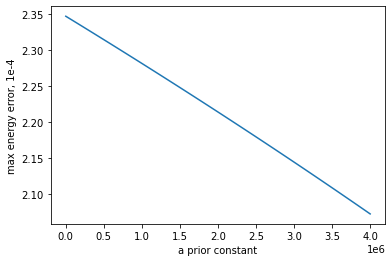

In [418]:
plt.plot(apriors[(sigmas != 0)], sigmas[(sigmas != 0)]*1e4)
plt.xlabel("a prior constant")
plt.ylabel("max energy error, 1e-4")
#plt.savefig("max_energy_error_aprior_constant.png", dpi=300)

In [101]:
optimize.minimize(inversed_fisher_information_postorerior, x0=1*10**6, args=(b0, x_knots, derivatives, KEs, dist), method='L-BFGS-B', options={'maxfev':5000 ,'maxiter':5000, 'gtol': 1e-10, 'ftol': 10e-10})

<ipython-input-101-6bbbbb02f088>:1: OptimizeWarning: Unknown solver options: maxfev
  optimize.minimize(inversed_fisher_information_postorerior, x0=3700000, args=(b0, x_knots, derivatives, KEs, dist), method='L-BFGS-B', options={'maxfev':5000 ,'maxiter':5000, 'gtol': 1e-10, 'ftol': 10e-10})


      fun: 0.00023572178366958497
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.03820079e-11])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([3700000.])

In [409]:
%%time
aprior = 1.39*10**6
optimize.minimize(inversed_fisher_information_postorerior, x0=b0, args=(x_knots, derivatives, KEs, dist, aprior), method='L-BFGS-B', bounds=bnds, options={'maxfev':5000 ,'maxiter':5000})

<timed exec>:2: OptimizeWarning: Unknown solver options: maxfev


Wall time: 3min 3s


      fun: 0.00023760403722747494
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.88411570e-06,  5.85944057e-06,  1.12301688e-05,  9.17457299e-06,
        5.22356681e-06,  1.77471426e-06, -4.57178243e-07, -1.34791268e-06,
       -1.00678471e-06,  3.63039677e-07,  2.52829170e-06,  5.26832538e-06,
        8.39160826e-06,  8.36953120e-06,  5.04449456e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 80
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([4.37658769, 1.61458954, 0.        , 0.        , 0.18809836,
       0.70600369, 1.09068524, 1.67189379, 0.87422749, 0.09775575,
       0.        , 0.        , 0.        , 0.        , 0.28953262])

In [410]:
b1 = [5.99536811, 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.35182219, 1.83871332, 0.86881914, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.87101467]

inversed_fisher_information_postorerior(b1, x_knots, derivatives, KEs, dist, aprior)

0.00022551395632930797

In [411]:
optimize.dual_annealing(inversed_fisher_information_postorerior,x0=b1, args=(x_knots, derivatives, KEs, dist, aprior),bounds=list(zip(bl, bw)),no_local_search=True)

KeyboardInterrupt: 

In [200]:
bo = [5.99536811, 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.35182219, 1.83871332, 0.86881914, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.87101467]

b0 = np.ones(len(x_knots)- 6)
x = np.linspace(0.001, max_energy, 1000)
y0 = np.array([T(x, x_knots, b0) for x in x])
yo = np.array([T(x, x_knots, bo) for x in x])
yo = yo*np.sum(y0)/np.sum(yo)

In [356]:
y0 = np.array([T(x, x_knots, b0) for x in x])
np.sum(y0)

990.1777490052763

In [379]:
from scipy.integrate import quad
def integrateQ(func, a, b):
    res = quad(func, a,b)
    return res[0]

def integrateR(func, a, b, numPoints = 1000):
    points, step = np.linspace(a, b, numPoints, endpoint=True, retstep=True)
    return np.sum(func(points))*step

from scipy.integrate import simps
def integrateS(func, a, b, numPoints = 1000):
    x = np.linspace(a,b, numPoints, endpoint=True)
    return simps(x = x, y = func(x))

integrate = integrateQ

In [385]:
convolute = lambda f, g, a, b: np.vectorize(lambda x: integrate(lambda y: f(x-y)*g(y), a, b))
sigma = 1
g = lambda x : 1/np.sqrt(2*np.pi)/sigma*np.exp(-x*x/2/sigma/sigma)
time = lambda x : T(x, x_knots, bo)
time = np.vectorize(time)

In [386]:
%%time
conv = convolute(time, g, 0.001, max_energy)(x)

Wall time: 7min 6s


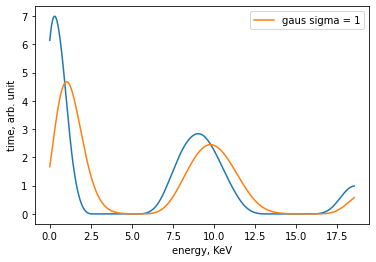

In [387]:
y0 = np.array([T(x, x_knots, b0) for x in x])
conv_normed = conv*np.sum(y0)/np.sum(conv)
plt.plot(x, yo)
plt.plot(x, conv_normed, label='gaus sigma = 1')
plt.xlabel("energy, KeV")
plt.ylabel("time, arb. unit")
plt.legend()
#plt.savefig("figs/convolute_strategy_gaus_1_quad.png", dpi=150)

In [303]:
#using lmft
def resid(params, KEs, ydata):
    max_energy = params['max_energy'].value
    noise = params['noise'].value
    calibr = params['calibr'].value
    lin = params['lin'].value

    y_model = experimental_lin(KEs, max_energy, noise, calibr, lin)
    return y_model - ydata


params = lmfit.Parameters()
params.add('max_energy', 18.57, min=18, max=19)
params.add('noise', 0, min=-500, max=500)
params.add('calibr', 1, min=0, max=2)
params.add('lin', 10**4, min=10**3, max=10**5)

In [304]:
def residual(params):
    max_energy = params['max_energy'].value
    noise = params['noise'].value
    calibr = params['calibr'].value
    lin = params['lin'].value

    y_model = experimental_lin(KEs, max_energy, noise, calibr, lin)
    sigma = np.sqrt(y_model*y0)/y0
    return (y_model - y)/sigma

In [391]:
np.random.seed(20)
y0 = yo
y = np.random.poisson(dist*y0)/y0
mini = lmfit.Minimizer(residual, params, nan_policy='propagate')
out1 = mini.minimize(method='nealder')
lmfit.report_fit(out1.params, min_correl=0.01)

[[Variables]]
    max_energy:  18.5695795 +/- 2.1055e-04 (0.00%) (init = 18.57)
    noise:       40.2244787 +/- 26.9818006 (67.08%) (init = 0)
    calibr:      1.00013506 +/- 9.6453e-05 (0.01%) (init = 1)
    lin:         10042.7012 +/- 75.0047110 (0.75%) (init = 10000)
[[Correlations]] (unreported correlations are < 0.010)
    C(calibr, lin)        =  0.958
    C(noise, calibr)      =  0.802
    C(noise, lin)         =  0.733
    C(max_energy, lin)    =  0.521
    C(max_energy, calibr) =  0.271
    C(max_energy, noise)  =  0.031


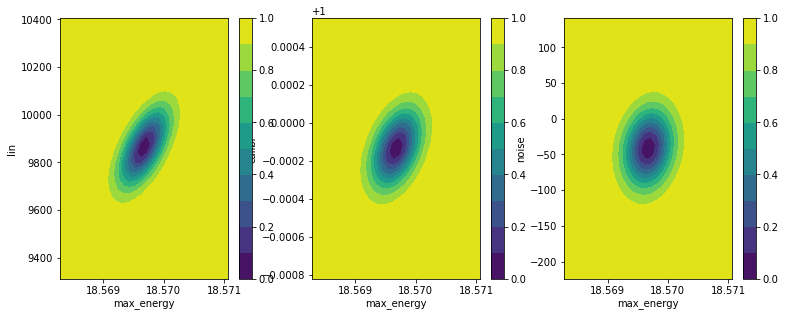

In [367]:
fig, axes = plt.subplots(1, 3, figsize=(12.8, 4.8))

cx, cy, grid = lmfit.conf_interval2d(mini, out1, 'max_energy', 'lin', 30, 30)
ctp = axes[0].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[0])
axes[0].set_xlabel('max_energy')
axes[0].set_ylabel('lin')
#axes[0].set_xticks([18.567, 18.5685, 18.57, 18.571])

cx, cy, grid = lmfit.conf_interval2d(mini, out1, 'max_energy', 'calibr', 30, 30)
ctp = axes[1].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[1])
axes[1].set_xlabel('max_energy')
axes[1].set_ylabel('calibr')
#axes[1].set_xticks([18.567, 18.5685, 18.57, 18.571])

cx, cy, grid = lmfit.conf_interval2d(mini, out1, 'max_energy', 'noise', 30, 30)
ctp = axes[2].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[2])
axes[2].set_xlabel('max_energy')
axes[2].set_ylabel('noise')
#axes[2].set_xticks([18.567, 18.5685, 18.57, 18.571])

#plt.savefig('figs/confidence_region_calibr_noise_initial_convolute_strategy_gaus_1.png', dpi=200)
plt.show()

In [368]:
inversed_fisher_information_postorerior(b0, x_knots, derivatives, KEs, dist, aprior=0)/2.8058e-04

1.4523241489369818

In [ ]:
## quad sigma = 0.5
[[Variables]]
    max_energy:  18.5697251 +/- 2.7356e-04 (0.00%) (init = 18.57)
    noise:       0.07463126 +/- 36.1331289 (48415.54%) (init = 0)
    calibr:      0.99998831 +/- 1.3483e-04 (0.01%) (init = 1)
    lin:         9950.20693 +/- 107.683543 (1.08%) (init = 10000)
[[Correlations]] (unreported correlations are < 0.010)
    C(calibr, lin)        =  0.970
    C(noise, calibr)      =  0.791
    C(noise, lin)         =  0.739
    C(max_energy, lin)    =  0.605
    C(max_energy, calibr) =  0.405
    C(max_energy, noise)  =  0.156
    
## simps sigma = 0.5
[[Variables]]
    max_energy:  18.5696753 +/- 2.7857e-04 (0.00%) (init = 18.57)
    noise:      -41.5087291 +/- 36.5055003 (87.95%) (init = 0)
    calibr:      0.99986524 +/- 1.3707e-04 (0.01%) (init = 1)
    lin:         9858.28320 +/- 109.516936 (1.11%) (init = 10000)
[[Correlations]] (unreported correlations are < 0.010)
    C(calibr, lin)        =  0.969
    C(noise, calibr)      =  0.791
    C(noise, lin)         =  0.739
    C(max_energy, lin)    =  0.606
    C(max_energy, calibr) =  0.405
    C(max_energy, noise)  =  0.156
    
## quad sigma = 1
[[Variables]]
    max_energy:  18.5695071 +/- 2.9162e-04 (0.00%) (init = 18.57)
    noise:       0.02528637 +/- 36.5321510 (144473.66%) (init = 0)
    calibr:      1.00001034 +/- 1.3036e-04 (0.01%) (init = 1)
    lin:         9944.80140 +/- 110.280297 (1.11%) (init = 10000)
[[Correlations]] (unreported correlations are < 0.010)
    C(calibr, lin)        =  0.971
    C(noise, calibr)      =  0.733
    C(max_energy, lin)    =  0.714
    C(noise, lin)         =  0.686
    C(max_energy, calibr) =  0.536
    C(max_energy, noise)  =  0.238

In [388]:
inversed_fisher_information_postorerior(b0, x_knots, derivatives, KEs, dist, aprior=0)/inversed_fisher_information_postorerior(bo, x_knots, derivatives, KEs, dist, aprior=0)

1.7364144837187998

In [389]:
inversed_fisher_information_postorerior(b0, x_knots, derivatives, KEs, dist, aprior=0)/2.9162e-04

1.3973428081364048

In [390]:
inversed_fisher_information_postorerior(b0, x_knots, derivatives, KEs, dist, aprior=0)/2.7356e-04

1.4895931777626055